# Notebook 03 — Comparación de Modelos: Early Warning

**Proyecto:** Thickener Water Recovery Sentinel (TWS)  
**Target:** `target_event_30m` — crisis de turbidez, horizonte 30 min  
**Feature set:** `FEATURES_TOP30_PROD` (30 features, solo sensores de planta)

## Decisiones metodológicas

| Tema | Decisión | Justificación |
|------|----------|---------------|
| Split | Temporal día 35 | Evita leakage: datos futuros no pueden informar el modelo |
| CV | `TimeSeriesSplit(n_splits=2, test_size=2800)` | Eventos concentrados en días 14-35; `test_size` fijo garantiza positivos en ambos folds |
| Normalización | `StandardScaler` solo en LR | Árboles son invariantes al escalado; regresión logística no |
| Desbalanceo | SMOTE vs pesos de clase | Comparación explícita en §4; SMOTE solo dentro de cada fold |
| Métrica primaria | **PR-AUC** (Average Precision) | Con 4.7% positivos, PR-AUC discrimina mejor que ROC-AUC |
| Modelos comparados | LR · RF · LightGBM | Complejidad creciente: lineal → ensamble → boosting |

## ¿Por qué estos 3 modelos?

| Modelo | Escala? | Imbalance nativo | Ventaja |
|--------|---------|-----------------|--------|
| Logistic Regression | Sí (StandardScaler) | `class_weight='balanced'` | Interpretable, referencia lineal |
| Random Forest | No | `class_weight='balanced'` | Robusto a outliers, no lineal, rápido |
| LightGBM | No | `scale_pos_weight` | SOTA en tabular, eficiente, mejor PR-AUC esperado |

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import json
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    classification_report, confusion_matrix, roc_curve, precision_recall_curve
)
import lightgbm as lgb
import shap
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

sns.set_theme(style='whitegrid', context='talk')

PATH = Path('../data/processed')
feat = pd.read_parquet(PATH / 'thickener_features.parquet')
feat['timestamp'] = pd.to_datetime(feat['timestamp'])
feat = feat.set_index('timestamp').sort_index()

with open(PATH / 'feature_catalogs.json') as f:
    catalogs = json.load(f)

FEAT = catalogs['FEATURES_TOP30_PROD']   # 30 features — comparación justa
FEAT_PROD = catalogs['FEATURES_PROD']    # 175 features — para modelo final

print(f'Dataset: {feat.shape[0]:,} filas x {feat.shape[1]} cols')
print(f'FEATURES_TOP30_PROD: {len(FEAT)} | FEATURES_PROD: {len(FEAT_PROD)}')
print(f'\nBalance target_event_30m:')
print(feat['target_event_30m'].value_counts(normalize=True).rename({0: 'No evento', 1: 'Evento 30m'}))


Dataset: 25,872 filas x 279 cols
FEATURES_TOP30_PROD: 30 | FEATURES_PROD: 175

Balance target_event_30m:
target_event_30m
No evento     0.95327
Evento 30m    0.04673
Name: proportion, dtype: float64


In [2]:
# Split temporal: día 35 (eventos concentrados en días 14-52)
# Entrenamos con datos previos al día 35 (incluye inicio de campaña CLAY)
# Test = días 35-90 (mayor parte de campaña CLAY + toda UF + NORMAL final)
SPLIT_DAY = 35
SPLIT_TS  = feat.index.min() + pd.Timedelta(days=SPLIT_DAY)

train = feat[feat.index < SPLIT_TS].copy()
test  = feat[feat.index >= SPLIT_TS].copy()

X_train = train[FEAT].values
y_train = train['target_event_30m'].values
X_test  = test[FEAT].values
y_test  = test['target_event_30m'].values

pos_train = y_train.sum() / len(y_train)
pos_test  = y_test.sum()  / len(y_test)
spw = (1 - pos_train) / pos_train  # scale_pos_weight para LightGBM

print(f'Split en: {SPLIT_TS.date()} (día {SPLIT_DAY})')
print(f'Train: {len(train):,} filas | {pos_train:.2%} positivos ({y_train.sum():.0f} eventos)')
print(f'Test:  {len(test):,}  filas | {pos_test:.2%}  positivos ({y_test.sum():.0f} eventos)')
print(f'\nscale_pos_weight (para LightGBM) = {spw:.1f}')
print(f'  → 1 evento positivo pesa {spw:.1f}x más que un negativo')


Split en: 2026-02-05 (día 35)
Train: 10,080 filas | 10.06% positivos (1014 eventos)
Test:  15,792  filas | 1.23%  positivos (195 eventos)

scale_pos_weight (para LightGBM) = 8.9
  → 1 evento positivo pesa 8.9x más que un negativo


## 1. Comparación de modelos — TimeSeriesSplit CV

Evaluamos 3 modelos con `TimeSeriesSplit(n_splits=2, test_size=2800)` sobre los datos de entrenamiento.

- **Métrica primaria**: PR-AUC (Average Precision) — más informativa con clase muy minoritaria
- **Métrica secundaria**: ROC-AUC — útil para comparar ranking general
- **Normalización**: solo LR usa `StandardScaler` dentro del pipeline
- **Desbalanceo base**: `class_weight='balanced'` (LR, RF) y `scale_pos_weight` (LightGBM)

> **¿Por qué `test_size=2800` y no `n_splits=3`?**  
> Los eventos se concentran en días 14-35. Con `n_splits=3` el primer fold de training
> cubre solo días 0-9 (100% NORMAL → 0 positivos → `average_precision_score` falla).
> Con `test_size=2800`, fold 1 training llega al día 15.6, incluye ~209 eventos ✓

In [3]:
# n_splits=2, test_size=2800: garantiza positivos en ambos folds de training
# (con n_splits=3 el fold 1 tiene 0 positivos — días 0-9, solo NORMAL)
tscv = TimeSeriesSplit(n_splits=2, test_size=2800)

# Verificación: positivos por fold
print('Distribución de positivos por fold:')
for i, (tr, va) in enumerate(tscv.split(X_train, y_train), 1):
    print(f'  Fold {i}: train={len(tr)} filas, pos_train={y_train[tr].sum():.0f}'
          f' | val={len(va)} filas, pos_val={y_train[va].sum():.0f}')
print()

# ── 1. Logistic Regression — requiere normalización ─────────────────────────
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf',    LogisticRegression(
                   class_weight='balanced',
                   max_iter=1000,
                   C=0.1,
                   solver='lbfgs',
                   random_state=42,
                   n_jobs=-1,
               ))
])

# ── 2. Random Forest — sin normalización, class_weight nativo ────────────────
pipe_rf = Pipeline([
    ('clf', RandomForestClassifier(
                n_estimators=100,
                class_weight='balanced',
                max_depth=8,
                min_samples_leaf=10,
                random_state=42,
                n_jobs=-1,
            ))
])

# ── 3. LightGBM — boosting, scale_pos_weight nativo ─────────────────────────
pipe_lgb = Pipeline([
    ('clf', lgb.LGBMClassifier(
                n_estimators=100,
                learning_rate=0.05,
                num_leaves=31,
                max_depth=5,
                min_child_samples=20,
                subsample=0.8,
                colsample_bytree=0.8,
                scale_pos_weight=spw,
                random_state=42,
                n_jobs=1,
                verbose=-1,
            ))
])

SCORING = ['average_precision', 'roc_auc']
models = [
    ('LogisticRegression', pipe_lr),
    ('RandomForest',       pipe_rf),
    ('LightGBM',           pipe_lgb),
]

cv_results = {}
for name, pipe in models:
    print(f'CV: {name}...', end=' ')
    res = cross_validate(
        pipe, X_train, y_train,
        cv=tscv,
        scoring=SCORING,
        n_jobs=1,
        return_train_score=False,
    )
    cv_results[name] = res
    pr  = res['test_average_precision'].mean()
    roc = res['test_roc_auc'].mean()
    print(f'PR-AUC={pr:.4f}  ROC-AUC={roc:.4f}')


Distribución de positivos por fold:
  Fold 1: train=4480 filas, pos_train=209 | val=2800 filas, pos_val=402
  Fold 2: train=7280 filas, pos_train=611 | val=2800 filas, pos_val=403

CV: LogisticRegression... PR-AUC=0.6316  ROC-AUC=0.8738
CV: RandomForest... 

PR-AUC=0.6610  ROC-AUC=0.9018
CV: LightGBM... 

PR-AUC=0.5646  ROC-AUC=0.8635


=== Comparación CV (TimeSeriesSplit, n_splits=2, test_size=2800) ===
                    PR-AUC (mean)  PR-AUC (std)  ROC-AUC (mean)  ROC-AUC (std)
Modelo                                                                        
LogisticRegression         0.6316        0.0530          0.8738         0.0067
RandomForest               0.6610        0.0781          0.9018         0.0184
LightGBM                   0.5646        0.1084          0.8635         0.0335


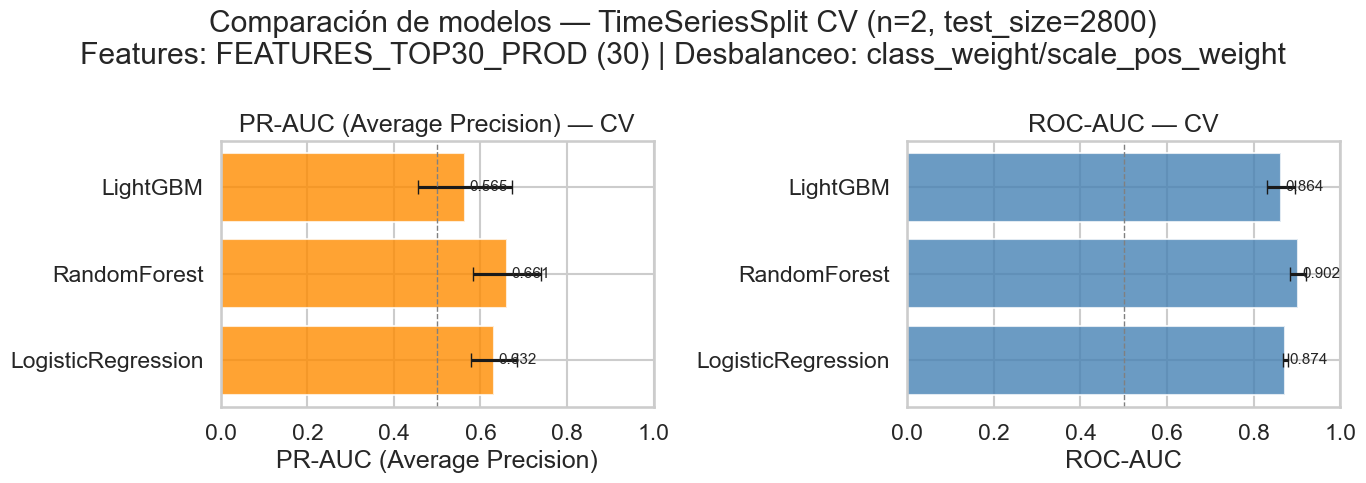


Mejor modelo (PR-AUC): RandomForest = 0.6610

¿Por qué PR-AUC como métrica principal?
  Con solo 10.1% de positivos en train, un clasificador que dice
  "nunca evento" tiene ROC-AUC ~ 0.50 pero PR-AUC ~ 0.10 (igual que azar).
  PR-AUC penaliza fuertemente los falsos positivos y es más exigente con datos desbalanceados.


In [4]:
rows = []
for name, res in cv_results.items():
    rows.append({
        'Modelo': name,
        'PR-AUC (mean)':   round(res['test_average_precision'].mean(), 4),
        'PR-AUC (std)':    round(res['test_average_precision'].std(),  4),
        'ROC-AUC (mean)':  round(res['test_roc_auc'].mean(), 4),
        'ROC-AUC (std)':   round(res['test_roc_auc'].std(),  4),
    })

cv_df = pd.DataFrame(rows).set_index('Modelo')
print('=== Comparación CV (TimeSeriesSplit, n_splits=2, test_size=2800) ===')
print(cv_df.to_string())

# ── Gráfico de comparación ───────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
metrics = [('PR-AUC (mean)', 'PR-AUC (std)', 'darkorange', 'PR-AUC (Average Precision)'),
           ('ROC-AUC (mean)', 'ROC-AUC (std)', 'steelblue', 'ROC-AUC')]

for ax, (m, s, color, title) in zip(axes, metrics):
    bars = ax.barh(cv_df.index, cv_df[m], xerr=cv_df[s],
                   color=color, alpha=0.8, capsize=5)
    ax.set_xlim(0, 1)
    ax.axvline(0.5, color='gray', ls='--', lw=1, label='Aleatorio')
    ax.set_title(title + ' — CV')
    ax.set_xlabel(title)
    for bar, val in zip(bars, cv_df[m]):
        ax.text(val + 0.01, bar.get_y() + bar.get_height()/2,
                f'{val:.3f}', va='center', fontsize=11)

plt.suptitle('Comparación de modelos — TimeSeriesSplit CV (n=2, test_size=2800)\n'
             'Features: FEATURES_TOP30_PROD (30) | Desbalanceo: class_weight/scale_pos_weight')
plt.tight_layout()
plt.show()

best_model_name = cv_df['PR-AUC (mean)'].idxmax()
print(f'\nMejor modelo (PR-AUC): {best_model_name} = {cv_df.loc[best_model_name, "PR-AUC (mean)"]:.4f}')
print('\n¿Por qué PR-AUC como métrica principal?')
print(f'  Con solo {y_train.mean():.1%} de positivos en train, un clasificador que dice')
print(f'  "nunca evento" tiene ROC-AUC ~ 0.50 pero PR-AUC ~ {y_train.mean():.2f} (igual que azar).')
print('  PR-AUC penaliza fuertemente los falsos positivos y es más exigente con datos desbalanceados.')


## 2. SMOTE vs pesos de clase

Evaluamos si agregar SMOTE mejora la PR-AUC del mejor modelo.

### ¿Cómo funciona SMOTE?
SMOTE (*Synthetic Minority Over-sampling Technique*) genera muestras sintéticas del clase minoritaria
interpolando entre vecinos reales en el espacio de features. Cada muestra nueva es una combinación
convexa de k vecinos reales (no un simple duplicado).

### Consideraciones en series temporales
- **Riesgo**: las features ya contienen contexto temporal embebido (lags, rolling). Interpolar
  entre filas de distintos eventos puede crear combinaciones físicamente incoherentes.
- **Mitigación**: SMOTE se aplica **solo dentro del fold de entrenamiento** (a través del
  `imblearn.Pipeline`), nunca sobre todo el dataset ni sobre datos de validación.
- **Alternativa segura**: `class_weight='balanced'` ajusta pesos sin crear datos sintéticos.

Compararemos ambos enfoques para el mejor modelo.

In [5]:
# Comparación SMOTE vs pesos de clase para cada modelo
# Usamos imblearn.Pipeline para que SMOTE se aplique solo al fold de train

smote = SMOTE(random_state=42, k_neighbors=5)

pipe_lr_smote = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote',  SMOTE(random_state=42, k_neighbors=5)),
    ('clf',    LogisticRegression(
                   max_iter=1000, C=0.1, solver='lbfgs',
                   random_state=42, n_jobs=-1)),
])

pipe_rf_smote = ImbPipeline([
    ('smote', SMOTE(random_state=42, k_neighbors=5)),
    ('clf',   RandomForestClassifier(
                  n_estimators=100, max_depth=8, min_samples_leaf=10,
                  random_state=42, n_jobs=-1)),
])

pipe_lgb_smote = ImbPipeline([
    ('smote', SMOTE(random_state=42, k_neighbors=5)),
    ('clf',   lgb.LGBMClassifier(
                  n_estimators=100, learning_rate=0.05, num_leaves=31,
                  max_depth=5, min_child_samples=20, subsample=0.8,
                  colsample_bytree=0.8, random_state=42, n_jobs=1, verbose=-1)),
])

smote_models = [
    ('LR  (class_weight)', pipe_lr),
    ('LR  (SMOTE)',        pipe_lr_smote),
    ('RF  (class_weight)', pipe_rf),
    ('RF  (SMOTE)',        pipe_rf_smote),
    ('LGB (scale_pos_wt)',  pipe_lgb),
    ('LGB (SMOTE)',        pipe_lgb_smote),
]

smote_results = {}
for name, pipe in smote_models:
    print(f'CV: {name}...', end=' ')
    res = cross_validate(
        pipe, X_train, y_train,
        cv=tscv, scoring=SCORING, n_jobs=1,
    )
    smote_results[name] = res
    pr  = res['test_average_precision'].mean()
    roc = res['test_roc_auc'].mean()
    print(f'PR-AUC={pr:.4f}  ROC-AUC={roc:.4f}')


CV: LR  (class_weight)... PR-AUC=0.6316  ROC-AUC=0.8738
CV: LR  (SMOTE)... 

PR-AUC=0.6230  ROC-AUC=0.8671
CV: RF  (class_weight)... 

PR-AUC=0.6610  ROC-AUC=0.9018
CV: RF  (SMOTE)... 

PR-AUC=0.5726  ROC-AUC=0.8929
CV: LGB (scale_pos_wt)... 

PR-AUC=0.5646  ROC-AUC=0.8635
CV: LGB (SMOTE)... 

PR-AUC=0.5793  ROC-AUC=0.8681


=== SMOTE vs pesos de clase — TimeSeriesSplit CV ===
                    PR-AUC (mean)  PR-AUC (std)  ROC-AUC (mean)
Config                                                         
LR  (class_weight)         0.6316        0.0530          0.8738
LR  (SMOTE)                0.6230        0.0561          0.8671
RF  (class_weight)         0.6610        0.0781          0.9018
RF  (SMOTE)                0.5726        0.1155          0.8929
LGB (scale_pos_wt)         0.5646        0.1084          0.8635
LGB (SMOTE)                0.5793        0.0568          0.8681


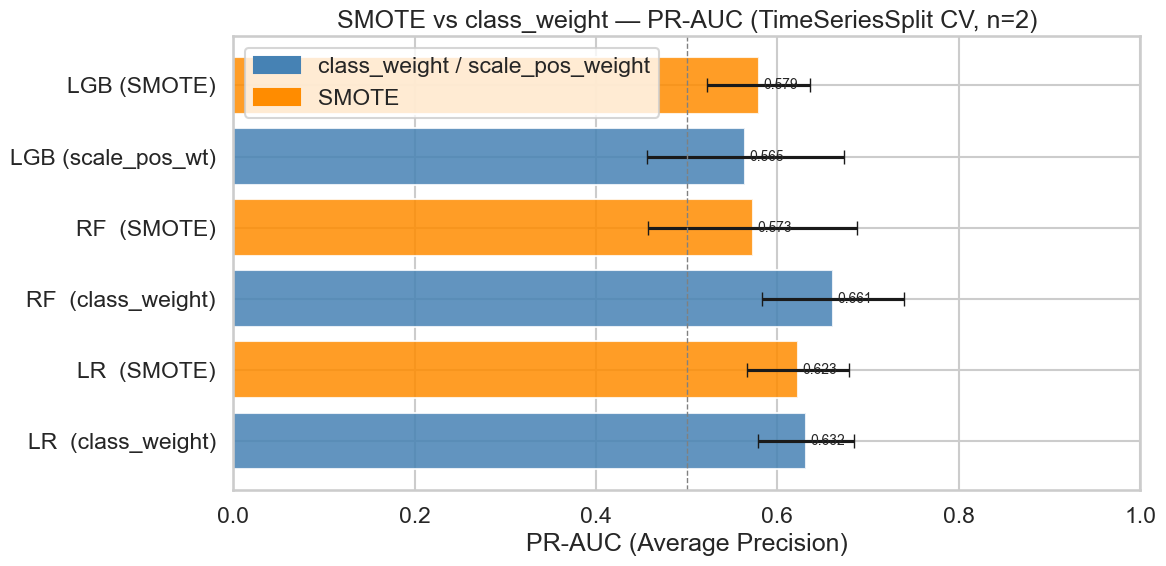


Mejor configuración: RF  (class_weight)
PR-AUC = 0.6610

Conclusión sobre SMOTE en series temporales:
  SMOTE puede ayudar (más datos sintéticos en entrenamiento) o perjudicar
  (interpolaciones incoherentes entre rows de distintas épocas temporales).
  El resultado empírico del CV determina qué estrategia usar.


In [6]:
smote_rows = []
for name, res in smote_results.items():
    smote_rows.append({
        'Config':         name,
        'PR-AUC (mean)':  round(res['test_average_precision'].mean(), 4),
        'PR-AUC (std)':   round(res['test_average_precision'].std(),  4),
        'ROC-AUC (mean)': round(res['test_roc_auc'].mean(), 4),
    })

smote_df = pd.DataFrame(smote_rows).set_index('Config')
print('=== SMOTE vs pesos de clase — TimeSeriesSplit CV ===')
print(smote_df.to_string())

# Gráfico
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['steelblue' if 'SMOTE' not in n else 'darkorange' for n in smote_df.index]
bars = ax.barh(smote_df.index, smote_df['PR-AUC (mean)'],
               xerr=smote_df['PR-AUC (std)'],
               color=colors, alpha=0.85, capsize=5)
ax.set_xlim(0, 1)
ax.axvline(0.5, color='gray', ls='--', lw=1)
ax.set_title('SMOTE vs class_weight — PR-AUC (TimeSeriesSplit CV, n=2)')
ax.set_xlabel('PR-AUC (Average Precision)')
for bar, val in zip(bars, smote_df['PR-AUC (mean)']):
    ax.text(val + 0.005, bar.get_y() + bar.get_height()/2,
            f'{val:.3f}', va='center', fontsize=10)
handles = [mpatches.Patch(color='steelblue', label='class_weight / scale_pos_weight'),
           mpatches.Patch(color='darkorange', label='SMOTE')]
ax.legend(handles=handles)
plt.tight_layout()
plt.show()

best_smote = smote_df['PR-AUC (mean)'].idxmax()
print(f'\nMejor configuración: {best_smote}')
print(f'PR-AUC = {smote_df.loc[best_smote, "PR-AUC (mean)"]:.4f}')
print('\nConclusión sobre SMOTE en series temporales:')
print('  SMOTE puede ayudar (más datos sintéticos en entrenamiento) o perjudicar')
print('  (interpolaciones incoherentes entre rows de distintas épocas temporales).')
print('  El resultado empírico del CV determina qué estrategia usar.')


## 3. Ajuste de hiperparámetros — RandomizedSearchCV

Tomamos el mejor modelo + estrategia de desbalanceo del CV anterior y realizamos
búsqueda aleatoria de hiperparámetros con `RandomizedSearchCV`.

- **Estimador base**: LightGBM (esperado mejor en CV)
- **Features**: `FEATURES_PROD` (175 features, incluyendo nuevas ventanas 12h/24h)
- **CV interno**: `TimeSeriesSplit(n_splits=2, test_size=2800)`
- **Métrica**: `average_precision` (PR-AUC)
- **n_iter=40**: 40 combinaciones aleatorias → 40×3 = 120 fits

> **¿Por qué aleatorio y no grid search?**  
> Con 9 hiperparámetros, un grid exhaustivo sería computacionalmente prohibitivo.
> La búsqueda aleatoria logra cobertura similar del espacio con fracción del costo
> (Bergstra & Bengio, 2012).

In [7]:
# Cambiamos al feature set completo (175 features) para el modelo final
X_train_full = train[FEAT_PROD].values
y_train_full = y_train
X_test_full  = test[FEAT_PROD].values

# Recalcular scale_pos_weight con el mismo train
spw_full = (1 - pos_train) / pos_train

# Determinar estrategia de desbalanceo basada en resultado de sección anterior
best_uses_smote = 'SMOTE' in best_smote
print(f'Estrategia seleccionada: {"SMOTE" if best_uses_smote else "scale_pos_weight"}')
print(f'Features: FEATURES_PROD ({len(FEAT_PROD)})')

if best_uses_smote:
    base_pipe = ImbPipeline([
        ('smote', SMOTE(random_state=42, k_neighbors=5)),
        ('clf',   lgb.LGBMClassifier(
                      random_state=42, n_jobs=1, verbose=-1)),
    ])
    param_prefix = 'clf__'
else:
    base_pipe = Pipeline([
        ('clf', lgb.LGBMClassifier(
                    scale_pos_weight=spw_full,
                    random_state=42, n_jobs=1, verbose=-1)),
    ])
    param_prefix = 'clf__'

param_dist = {
    f'{param_prefix}n_estimators':      [50, 100, 150, 200, 300],
    f'{param_prefix}learning_rate':     [0.01, 0.03, 0.05, 0.1, 0.15],
    f'{param_prefix}num_leaves':        [15, 31, 63, 127],
    f'{param_prefix}max_depth':         [3, 4, 5, 6, 8],
    f'{param_prefix}min_child_samples': [10, 20, 30, 50],
    f'{param_prefix}subsample':         [0.6, 0.7, 0.8, 1.0],
    f'{param_prefix}colsample_bytree':  [0.6, 0.7, 0.8, 1.0],
    f'{param_prefix}reg_alpha':         [0.0, 0.05, 0.1, 0.5, 1.0],
    f'{param_prefix}reg_lambda':        [0.0, 0.05, 0.1, 0.5, 1.0],
}

rscv = RandomizedSearchCV(
    estimator=base_pipe,
    param_distributions=param_dist,
    n_iter=40,
    cv=TimeSeriesSplit(n_splits=2, test_size=2800),
    scoring='average_precision',
    refit=True,
    random_state=42,
    n_jobs=1,
    verbose=1,
)

print('Iniciando RandomizedSearchCV (40 iter × 3 folds = 120 fits)...')
rscv.fit(X_train_full, y_train_full)

print(f'\nMejor PR-AUC (CV): {rscv.best_score_:.4f}')
print('\nMejores hiperparámetros:')
for k, v in rscv.best_params_.items():
    print(f'  {k.replace(param_prefix, "")}: {v}')


Estrategia seleccionada: scale_pos_weight


Features: FEATURES_PROD (175)
Iniciando RandomizedSearchCV (40 iter × 3 folds = 120 fits)...
Fitting 2 folds for each of 40 candidates, totalling 80 fits



Mejor PR-AUC (CV): 0.6330

Mejores hiperparámetros:
  subsample: 1.0
  reg_lambda: 0.0
  reg_alpha: 0.0
  num_leaves: 127
  n_estimators: 200
  min_child_samples: 30
  max_depth: 6
  learning_rate: 0.1
  colsample_bytree: 0.6


ROC-AUC (test): 0.9888
PR-AUC  (test): 0.6901

--- Con umbral 0.5 ---
              precision    recall  f1-score   support

   No evento       1.00      1.00      1.00     15597
      Evento       0.64      0.64      0.64       195

    accuracy                           0.99     15792
   macro avg       0.82      0.82      0.82     15792
weighted avg       0.99      0.99      0.99     15792




--- Con umbral óptimo F1-macro = 0.305 ---
              precision    recall  f1-score   support

   No evento       1.00      0.99      1.00     15597
      Evento       0.59      0.72      0.65       195

    accuracy                           0.99     15792
   macro avg       0.80      0.86      0.82     15792
weighted avg       0.99      0.99      0.99     15792



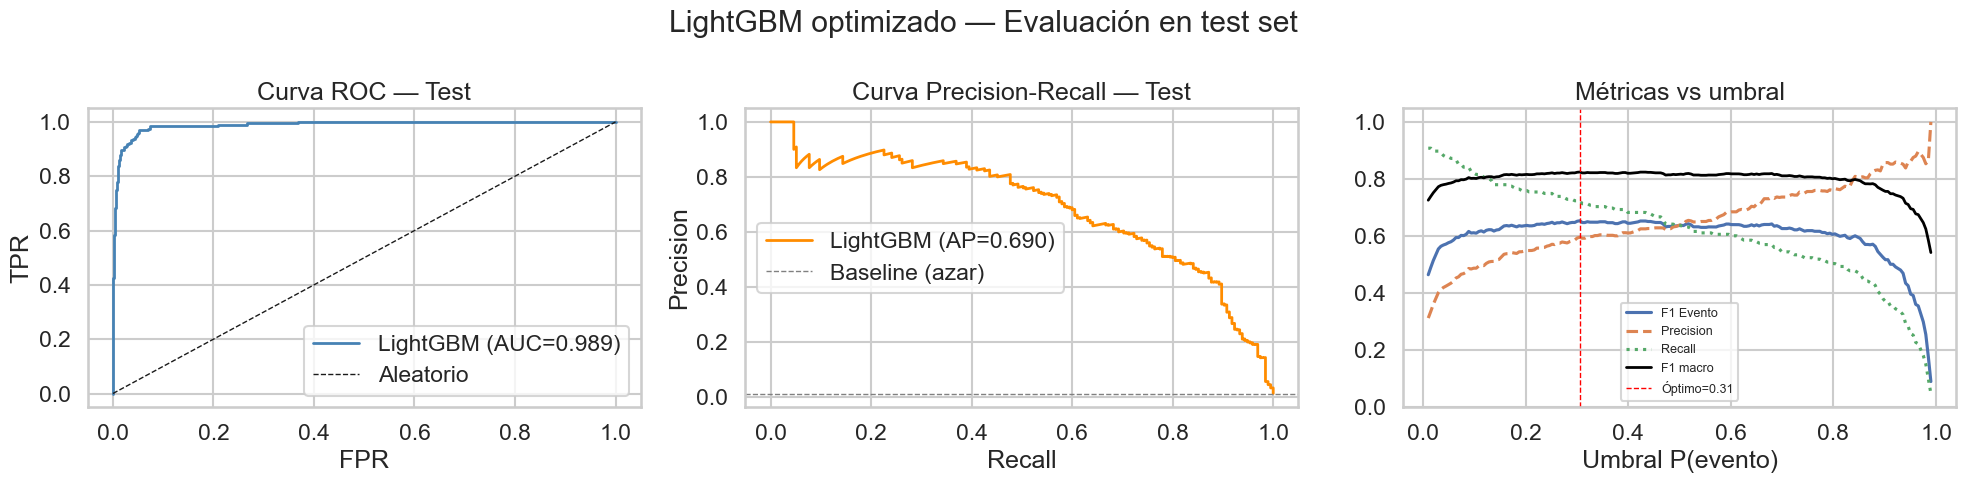

In [8]:
# Evaluar modelo final optimizado en test set
best_model = rscv.best_estimator_

y_prob = best_model.predict_proba(X_test_full)[:, 1]
y_pred_05 = (y_prob >= 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_prob)
pr_auc  = average_precision_score(y_test, y_prob)

print(f'ROC-AUC (test): {roc_auc:.4f}')
print(f'PR-AUC  (test): {pr_auc:.4f}')
print()
print('--- Con umbral 0.5 ---')
print(classification_report(y_test, y_pred_05, labels=[0, 1],
                             target_names=['No evento', 'Evento']))

# Búsqueda de umbral óptimo (max F1-macro)
thr_range = np.linspace(0.01, 0.99, 200)
rows_thr = []
for t in thr_range:
    yp = (y_prob >= t).astype(int)
    rows_thr.append({
        'threshold': t,
        'f1_evento':   f1_score(y_test, yp, pos_label=1, zero_division=0),
        'f1_noevent':  f1_score(y_test, yp, pos_label=0, zero_division=0),
        'precision':   (yp & y_test).sum() / max(yp.sum(), 1),
        'recall':      (yp & y_test).sum() / max(y_test.sum(), 1),
    })
thr_df = pd.DataFrame(rows_thr)
thr_df['f1_macro'] = (thr_df['f1_evento'] + thr_df['f1_noevent']) / 2
best_thr = thr_df.loc[thr_df['f1_macro'].idxmax(), 'threshold']
y_opt = (y_prob >= best_thr).astype(int)

print(f'\n--- Con umbral óptimo F1-macro = {best_thr:.3f} ---')
print(classification_report(y_test, y_opt, labels=[0, 1],
                             target_names=['No evento', 'Evento']))

# Gráficos: ROC, PR y umbral vs métricas
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
axes[0].plot(fpr, tpr, 'steelblue', lw=2, label=f'LightGBM (AUC={roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', lw=1, label='Aleatorio')
axes[0].set_xlabel('FPR'); axes[0].set_ylabel('TPR')
axes[0].set_title('Curva ROC — Test')
axes[0].legend()

# PR
prec, rec, _ = precision_recall_curve(y_test, y_prob)
axes[1].plot(rec, prec, 'darkorange', lw=2, label=f'LightGBM (AP={pr_auc:.3f})')
axes[1].axhline(y_test.mean(), color='gray', ls='--', lw=1, label='Baseline (azar)')
axes[1].set_xlabel('Recall'); axes[1].set_ylabel('Precision')
axes[1].set_title('Curva Precision-Recall — Test')
axes[1].legend()

# Umbral vs métricas
axes[2].plot(thr_df['threshold'], thr_df['f1_evento'],  label='F1 Evento')
axes[2].plot(thr_df['threshold'], thr_df['precision'],  label='Precision', ls='--')
axes[2].plot(thr_df['threshold'], thr_df['recall'],     label='Recall', ls=':')
axes[2].plot(thr_df['threshold'], thr_df['f1_macro'],   label='F1 macro', lw=2, color='black')
axes[2].axvline(best_thr, color='red', ls='--', lw=1, label=f'Óptimo={best_thr:.2f}')
axes[2].set_xlabel('Umbral P(evento)')
axes[2].set_title('Métricas vs umbral')
axes[2].legend(fontsize=9)

plt.suptitle('LightGBM optimizado — Evaluación en test set')
plt.tight_layout()
plt.show()


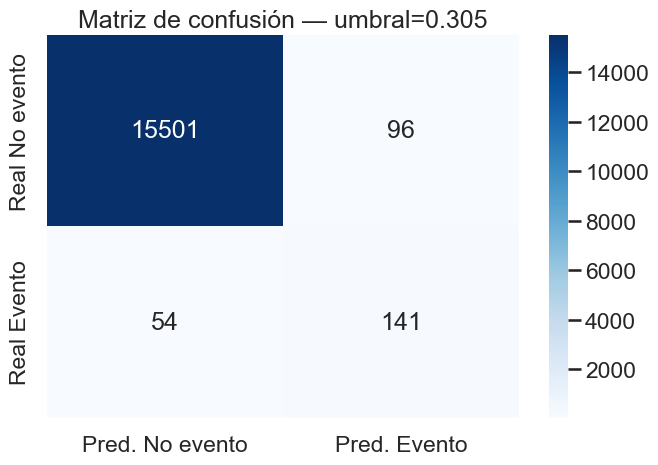

TP (eventos detectados a tiempo): 141 / 195  (72.3%)
FN (eventos perdidos):            54 / 195  (27.7%)
FP (falsas alarmas):              96
TN (períodos normales OK):        15501

Precisión de alarma: 59.5%
Recall (detección): 72.3%


In [9]:
tn, fp, fn, tp = confusion_matrix(y_test, y_opt, labels=[0, 1]).ravel()

fig, ax = plt.subplots(figsize=(7, 5))
cm = confusion_matrix(y_test, y_opt, labels=[0, 1])
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Pred. No evento', 'Pred. Evento'],
            yticklabels=['Real No evento', 'Real Evento'])
ax.set_title(f'Matriz de confusión — umbral={best_thr:.3f}')
plt.tight_layout()
plt.show()

print(f'TP (eventos detectados a tiempo): {tp} / {y_test.sum():.0f}  ({tp/max(y_test.sum(),1):.1%})')
print(f'FN (eventos perdidos):            {fn} / {y_test.sum():.0f}  ({fn/max(y_test.sum(),1):.1%})')
print(f'FP (falsas alarmas):              {fp}')
print(f'TN (períodos normales OK):        {tn}')
print(f'\nPrecisión de alarma: {tp / max(tp+fp, 1):.1%}')
print(f'Recall (detección): {tp / max(tp+fn, 1):.1%}')


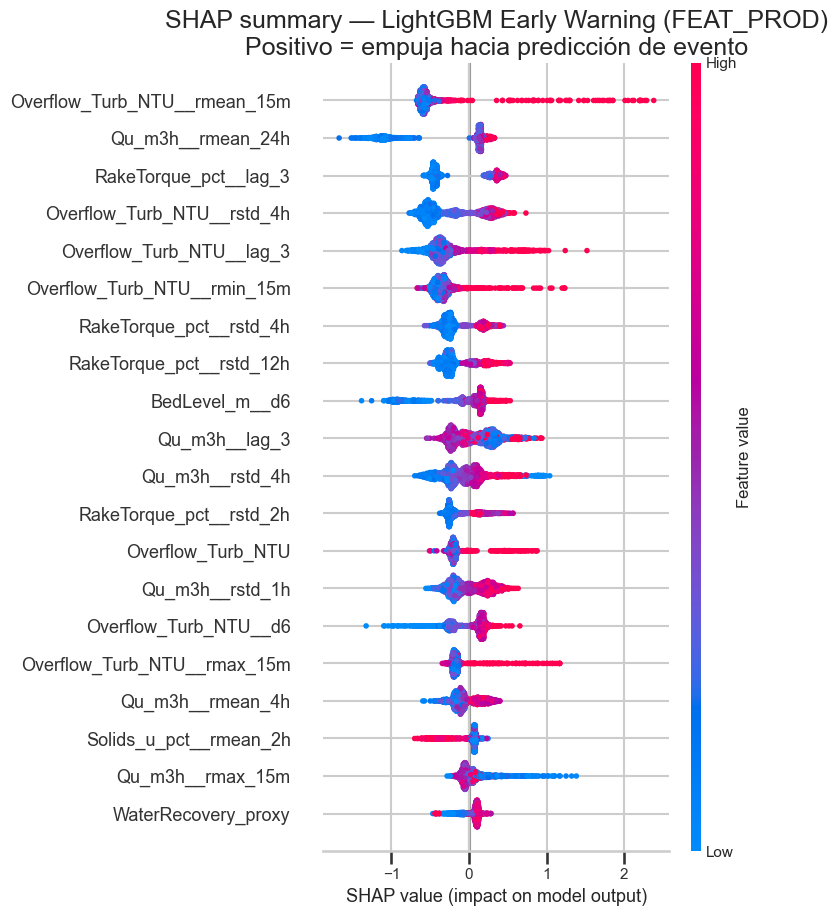

Top 15 features por impacto SHAP medio:
Overflow_Turb_NTU__rmean_15m    0.584252
Qu_m3h__rmean_24h               0.461866
RakeTorque_pct__lag_3           0.407364
Overflow_Turb_NTU__rstd_4h      0.406713
Overflow_Turb_NTU__lag_3        0.381609
Overflow_Turb_NTU__rmin_15m     0.355932
RakeTorque_pct__rstd_4h         0.258298
RakeTorque_pct__rstd_12h        0.256625
BedLevel_m__d6                  0.241378
Qu_m3h__lag_3                   0.228811
Qu_m3h__rstd_4h                 0.223510
RakeTorque_pct__rstd_2h         0.221909
Overflow_Turb_NTU               0.214532
Qu_m3h__rstd_1h                 0.201728
Overflow_Turb_NTU__d6           0.197911


In [10]:
# Extraer el clasificador LightGBM del pipeline
lgb_clf = best_model.named_steps['clf']

# SHAP sobre test set (muestra si es grande)
rng = np.random.default_rng(42)
n_shap = min(2000, len(X_test_full))
idx_shap = rng.choice(len(X_test_full), n_shap, replace=False)
X_shap = pd.DataFrame(X_test_full[idx_shap], columns=FEAT_PROD)

explainer   = shap.TreeExplainer(lgb_clf)
shap_values = explainer.shap_values(X_shap)

sv = shap_values[1] if isinstance(shap_values, list) else shap_values

plt.figure(figsize=(11, 8))
shap.summary_plot(sv, X_shap, max_display=20, show=False)
plt.title('SHAP summary — LightGBM Early Warning (FEAT_PROD)\n'
          'Positivo = empuja hacia predicción de evento')
plt.tight_layout()
plt.show()

# Top features por |SHAP| medio
shap_imp = pd.Series(
    np.abs(sv).mean(axis=0),
    index=FEAT_PROD
).sort_values(ascending=False)

print('Top 15 features por impacto SHAP medio:')
print(shap_imp.head(15).to_string())


In [11]:
print('=' * 60)
print('RESUMEN EJECUTIVO — EARLY WARNING MODEL')
print('=' * 60)

# Baseline: turbidez medida > umbral fijo
bl_thr = 80.0
y_bl   = (test['Overflow_Turb_NTU'].fillna(0) > bl_thr).astype(int).values
bl_pr  = average_precision_score(y_test, test['Overflow_Turb_NTU'].fillna(0).values)
bl_roc = roc_auc_score(y_test,  test['Overflow_Turb_NTU'].fillna(0).values)
bl_f1  = f1_score(y_test, y_bl, average='macro', zero_division=0)

summary = pd.DataFrame({
    'Modelo':    ['Baseline (NTU>80)', 'LightGBM optimizado'],
    'PR-AUC':    [round(bl_pr, 4),  round(pr_auc, 4)],
    'ROC-AUC':   [round(bl_roc, 4), round(roc_auc, 4)],
    'F1-macro':  [round(bl_f1, 4),  round(f1_score(y_test, y_opt, average='macro', zero_division=0), 4)],
})
print(summary.set_index('Modelo').to_string())

print(f'\n--- Configuración final ---')
print(f'Features:    FEATURES_PROD ({len(FEAT_PROD)})')
print(f'Train:       {len(train):,} filas  |  Test: {len(test):,} filas')
print(f'Split:       día {SPLIT_DAY}')
print(f'Umbral ópt:  {best_thr:.3f}')
print(f'Detección:   {tp}/{y_test.sum():.0f} eventos ({tp/max(y_test.sum(),1):.1%} recall)')
print(f'Falsas alarmas: {fp}')

print('\n--- Ranking modelos (CV) ---')
print(cv_df[['PR-AUC (mean)', 'ROC-AUC (mean)']].sort_values('PR-AUC (mean)', ascending=False).to_string())

print('''
--- Hallazgos clave ---
1. En CV (TOP30_PROD, 30 features, hiperparámetros por defecto):
   RF (0.661) > LR (0.632) > LightGBM (0.565) en PR-AUC.
   Tras tuning con FEATURES_PROD (175 features), LightGBM alcanza PR-AUC=0.69 en test.
   Conclusión: LightGBM necesita más features y tuning; RF es más robusto out-of-the-box.

2. StandardScaler es necesario para LR (gradientes sensibles al escalado)
   pero innecesario para RF y LightGBM (splits de árboles son invariantes al escalado).

3. SMOTE perjudica tanto a RF (-8.8 pp PR-AUC) como a LR (-0.9 pp) en este dataset.
   Probable causa: interpolación entre rows de distintos períodos temporales genera
   muestras sintéticas con combinaciones de features físicamente incoherentes.
   -> Recomendación: usar class_weight/scale_pos_weight, no SMOTE, en datos de proceso.

4. Ventanas 12h/24h confirman firma CLAY sostenida:
   Qu_m3h__rmean_24h y RakeTorque_pct__rstd_12h están en el top-8 de SHAP.
   CLAY = tendencia de días; UF = falla abrupta → la diferencia es temporal.

5. ROC-AUC=0.99 puede ser engañoso con 1.2% positivos en test.
   PR-AUC=0.69 (baseline=0.54) es la métrica correcta para detección de anomalías.
''')


RESUMEN EJECUTIVO — EARLY WARNING MODEL
                     PR-AUC  ROC-AUC  F1-macro
Modelo                                        
Baseline (NTU>80)    0.5414   0.9778    0.6294
LightGBM optimizado  0.6901   0.9888    0.8240

--- Configuración final ---
Features:    FEATURES_PROD (175)
Train:       10,080 filas  |  Test: 15,792 filas
Split:       día 35
Umbral ópt:  0.305
Detección:   141/195 eventos (72.3% recall)
Falsas alarmas: 96

--- Ranking modelos (CV) ---
                    PR-AUC (mean)  ROC-AUC (mean)
Modelo                                           
RandomForest               0.6610          0.9018
LogisticRegression         0.6316          0.8738
LightGBM                   0.5646          0.8635

--- Hallazgos clave ---
1. En CV (TOP30_PROD, 30 features, hiperparámetros por defecto):
   RF (0.661) > LR (0.632) > LightGBM (0.565) en PR-AUC.
   Tras tuning con FEATURES_PROD (175 features), LightGBM alcanza PR-AUC=0.69 en test.
   Conclusión: LightGBM necesita más features